In [1]:
import os

import pandas

%matplotlib widget
import matplotlib
import matplotlib.pyplot

import seaborn
import scipy.stats

import math
import numpy 

import datetime
import pytz

In [2]:
root_path = '/Users/matthieu/.ssh/ssh_to_graz/saved_graz_data/beetle/'

data_path = root_path + '2feeders/'
conf_path = root_path + 'config/'

data_file = data_path + '2feeders_exp_result_5mins.csv'

In [3]:
# From google sheets spreadsheet
data_raw = pandas.read_csv(data_file)

datetime_objects    = []
starttime_objects   = []
type_objects        = []

for ind, dat in data_raw.iterrows():

    dt_str          = dat.Date
    start_time_str  = dat.Time + ':00' # missing seconds in this one

    if dat.type == 1:
        type_str    = 'Control'  
    elif dat.type == 2:
        type_str    = 'Vibs to South'
    elif dat.type == 3:
        type_str    = 'Vibs to North'
    else :
        type_str    = 'None'


    datetime_objects.append(pytz.utc.localize(datetime.datetime.strptime(dt_str, "%d.%m.%y")))
    starttime_objects.append(pytz.utc.localize(datetime.datetime.strptime(dt_str+'T'+start_time_str, "%d.%m.%yT%H:%M:%S")))
    type_objects.append(type_str)


data_raw['dt'] = datetime_objects
data_raw['dtts_start'] = starttime_objects
data_raw['type_hr'] = type_objects
data_raw

,Date,Time,visits_s,recruits_s,removed_s,temperature_s,visits_n,recruits_n,removed_n,temperature_n,type,dt,dtts_start,type_hr
0,29.07.23,10:35,7.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2023-07-29 00:00:00+00:00,2023-07-29 10:35:00+00:00,None
1,29.07.23,10:40,9.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2023-07-29 00:00:00+00:00,2023-07-29 10:40:00+00:00,None
2,29.07.23,10:45,18.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2023-07-29 00:00:00+00:00,2023-07-29 10:45:00+00:00,None
3,29.07.23,10:50,16.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2023-07-29 00:00:00+00:00,2023-07-29 10:50:00+00:00,None
4,29.07.23,10:55,20.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2023-07-29 00:00:00+00:00,2023-07-29 10:55:00+00:00,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,31.07.23,16:50,8.0,3.0,1.0,29.0,7.0,0.0,0.0,37.0,1.0,2023-07-31 00:00:00+00:00,2023-07-31 16:50:00+00:00,Control
295,31.07.23,16:55,8.0,0.0,3.0,29.0,5.0,0.0,0.0,36.0,1.0,2023-07-31 00:00:00+00:00,2023-07-31 16:55:00+00:00,Control
296,31.07.23,17:00,5.0,0.0,0.0,29.0,4.0,0.0,0.0,35.0,1.0,2023-07-31 00:00:00+00:00,2023-07-31 17:00:00+00:00,Control
297,31.07.23,17:05,NaN,NaN,NaN,NaN,NaN,0.0,0.0,34.0,NaN,2023-07-31 00:00:00+00:00,2023-07-31 17:05:00+00:00,None


In [4]:
exp_duration = datetime.timedelta(minutes=30)
data_clean = data_raw[data_raw.type_hr != 'None'].fillna(0)

data_30mins = []
count_nb_periods = 0
start_timestamp = pytz.utc.localize(datetime.datetime(1994, 3, 26, 6, 25, 0))
stop_timestamp = []
data_point = {}
for dat_i, dat in data_clean.iterrows():
    if dat.dtts_start < start_timestamp + exp_duration:
        count_nb_periods += 1

        data_point['duration']          += datetime.timedelta(minutes=5)
        data_point['count_agregation']  = count_nb_periods
        data_point['visits_s']          += dat.visits_s
        data_point['visits_n']          += dat.visits_n
        data_point['removed_s']         += dat.removed_s
        data_point['removed_n']         += dat.removed_n
        data_point['recruits_s']        += dat.recruits_s
        data_point['recruits_n']        += dat.recruits_n 
        data_point['dtts_stop']         = data_point['dtts_start'] + data_point['duration']
    else :
        data_30mins.append(data_point)
        count_nb_periods = 1
        start_timestamp = dat.dtts_start
        data_point = {}
        data_point['dt']                = dat['dt']
        data_point['dtts_start']        = dat.dtts_start
        data_point['dtts_stop']         = []
        data_point['type']              = dat.type
        data_point['type_hr']           = dat.type_hr
        data_point['duration']          = datetime.timedelta(minutes=5)
        data_point['count_agregation']  = 1
        data_point['visits_s']          = dat.visits_s
        data_point['visits_n']          = dat.visits_n
        data_point['removed_s']         = dat.removed_s
        data_point['removed_n']         = dat.removed_n
        data_point['recruits_s']        = dat.recruits_s
        data_point['recruits_n']        = dat.recruits_n

    
data_30mins = pandas.DataFrame.from_dict(data_30mins[1:])
data_30mins

,dt,dtts_start,dtts_stop,type,type_hr,duration,count_agregation,visits_s,visits_n,removed_s,removed_n,recruits_s,recruits_n
0,2023-07-29 00:00:00+00:00,2023-07-29 13:00:00+00:00,2023-07-29 13:30:00+00:00,1.0,Control,0 days 00:30:00,6,50.0,32.0,5.0,0.0,2.0,2.0
1,2023-07-29 00:00:00+00:00,2023-07-29 13:30:00+00:00,2023-07-29 14:00:00+00:00,3.0,Vibs to North,0 days 00:30:00,6,45.0,25.0,5.0,0.0,0.0,0.0
2,2023-07-29 00:00:00+00:00,2023-07-29 14:00:00+00:00,2023-07-29 14:30:00+00:00,1.0,Control,0 days 00:30:00,6,26.0,19.0,4.0,0.0,0.0,2.0
3,2023-07-29 00:00:00+00:00,2023-07-29 14:30:00+00:00,2023-07-29 15:00:00+00:00,2.0,Vibs to South,0 days 00:30:00,6,38.0,35.0,15.0,0.0,1.0,3.0
4,2023-07-29 00:00:00+00:00,2023-07-29 15:00:00+00:00,2023-07-29 15:30:00+00:00,1.0,Control,0 days 00:30:00,6,43.0,33.0,22.0,0.0,5.0,2.0
5,2023-07-29 00:00:00+00:00,2023-07-29 15:30:00+00:00,2023-07-29 16:00:00+00:00,3.0,Vibs to North,0 days 00:30:00,6,45.0,22.0,2.0,0.0,0.0,2.0
6,2023-07-29 00:00:00+00:00,2023-07-29 16:00:00+00:00,2023-07-29 16:30:00+00:00,1.0,Control,0 days 00:30:00,6,28.0,15.0,1.0,0.0,0.0,2.0
7,2023-07-30 00:00:00+00:00,2023-07-30 10:00:00+00:00,2023-07-30 10:30:00+00:00,1.0,Control,0 days 00:30:00,6,48.0,36.0,5.0,6.0,3.0,3.0
8,2023-07-30 00:00:00+00:00,2023-07-30 10:30:00+00:00,2023-07-30 11:00:00+00:00,3.0,Vibs to North,0 days 00:30:00,6,33.0,30.0,6.0,2.0,8.0,2.0
9,2023-07-30 00:00:00+00:00,2023-07-30 11:00:00+00:00,2023-07-30 11:30:00+00:00,1.0,Control,0 days 00:30:00,6,36.0,30.0,7.0,3.0,14.0,3.0


In [5]:
data = data_30mins#[data_30mins.index != 9]
#data

data = data[data.dt != pytz.utc.localize(datetime.datetime(2023,7,31))]
data

,dt,dtts_start,dtts_stop,type,type_hr,duration,count_agregation,visits_s,visits_n,removed_s,removed_n,recruits_s,recruits_n
0,2023-07-29 00:00:00+00:00,2023-07-29 13:00:00+00:00,2023-07-29 13:30:00+00:00,1.0,Control,0 days 00:30:00,6,50.0,32.0,5.0,0.0,2.0,2.0
1,2023-07-29 00:00:00+00:00,2023-07-29 13:30:00+00:00,2023-07-29 14:00:00+00:00,3.0,Vibs to North,0 days 00:30:00,6,45.0,25.0,5.0,0.0,0.0,0.0
2,2023-07-29 00:00:00+00:00,2023-07-29 14:00:00+00:00,2023-07-29 14:30:00+00:00,1.0,Control,0 days 00:30:00,6,26.0,19.0,4.0,0.0,0.0,2.0
3,2023-07-29 00:00:00+00:00,2023-07-29 14:30:00+00:00,2023-07-29 15:00:00+00:00,2.0,Vibs to South,0 days 00:30:00,6,38.0,35.0,15.0,0.0,1.0,3.0
4,2023-07-29 00:00:00+00:00,2023-07-29 15:00:00+00:00,2023-07-29 15:30:00+00:00,1.0,Control,0 days 00:30:00,6,43.0,33.0,22.0,0.0,5.0,2.0
5,2023-07-29 00:00:00+00:00,2023-07-29 15:30:00+00:00,2023-07-29 16:00:00+00:00,3.0,Vibs to North,0 days 00:30:00,6,45.0,22.0,2.0,0.0,0.0,2.0
6,2023-07-29 00:00:00+00:00,2023-07-29 16:00:00+00:00,2023-07-29 16:30:00+00:00,1.0,Control,0 days 00:30:00,6,28.0,15.0,1.0,0.0,0.0,2.0
7,2023-07-30 00:00:00+00:00,2023-07-30 10:00:00+00:00,2023-07-30 10:30:00+00:00,1.0,Control,0 days 00:30:00,6,48.0,36.0,5.0,6.0,3.0,3.0
8,2023-07-30 00:00:00+00:00,2023-07-30 10:30:00+00:00,2023-07-30 11:00:00+00:00,3.0,Vibs to North,0 days 00:30:00,6,33.0,30.0,6.0,2.0,8.0,2.0
9,2023-07-30 00:00:00+00:00,2023-07-30 11:00:00+00:00,2023-07-30 11:30:00+00:00,1.0,Control,0 days 00:30:00,6,36.0,30.0,7.0,3.0,14.0,3.0


In [6]:
v2n_df = data[data.type == 3]
v2s_df = data[data.type == 2]
ctl_df = data[data.type == 1]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Average recruitment rates [South feeder, North feeder]: 
Control : [2.8461538461538463, 1.3846153846153846]
South Vibs : [1.2, 1.6]
North Vibs : [2.1666666666666665, 1.0]

Standard Devs [South feeder, North feeder]: 
Control : [3.782551031736691, 1.12089707663561]
South Vibs : [1.0954451150103324, 1.3416407864998738]
North Vibs : [3.125166662222459, 1.0954451150103321]



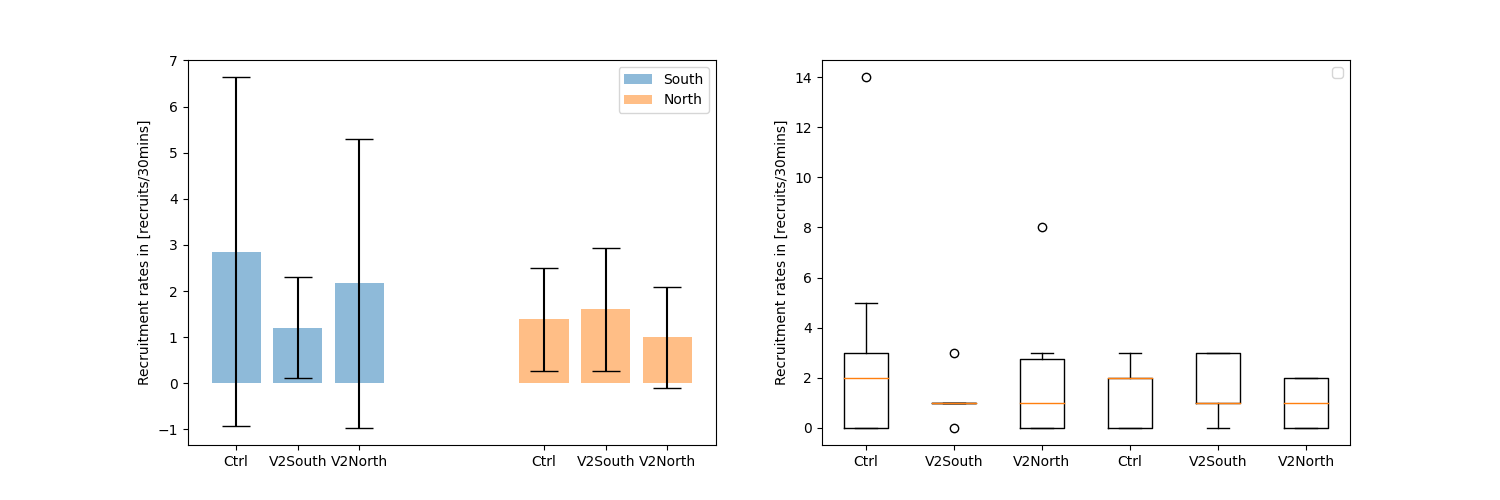

In [7]:
# Average views
ctl_ave = [ctl_df.recruits_s.mean(), ctl_df.recruits_n.mean()]
v2s_ave = [v2s_df.recruits_s.mean(), v2s_df.recruits_n.mean()]
v2n_ave = [v2n_df.recruits_s.mean(), v2n_df.recruits_n.mean()]
ctl_var = [ctl_df.recruits_s.std(), ctl_df.recruits_n.std()]
v2s_var = [v2s_df.recruits_s.std(), v2s_df.recruits_n.std()]
v2n_var = [v2n_df.recruits_s.std(), v2n_df.recruits_n.std()]
means_rec   = numpy.squeeze(numpy.array([[ctl_ave], [v2s_ave], [v2n_ave]]))
stds_rec    = numpy.squeeze(numpy.array([[ctl_var], [v2s_var], [v2n_var]]))

print('Average recruitment rates [South feeder, North feeder]: ')
print('Control : {}'.format(ctl_ave))
print('South Vibs : {}'.format(v2s_ave))
print('North Vibs : {}'.format(v2n_ave))
print()
print('Standard Devs [South feeder, North feeder]: ')
print('Control : {}'.format(ctl_var))
print('South Vibs : {}'.format(v2s_var))
print('North Vibs : {}'.format(v2n_var))
print()

fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(15,5))
ax[0].bar(range(0, 3), means_rec[:, 0], yerr=stds_rec[:, 0], align='center', alpha=0.5, ecolor='black', capsize=10, label='South')
ax[0].bar(range(5, 8), means_rec[:, 1], yerr=stds_rec[:, 1], align='center', alpha=0.5, ecolor='black', capsize=10, label='North')
ax[0].set_xticks([0,1,2,5,6,7])
ax[0].set_xticklabels(['Ctrl', 'V2South', 'V2North', 'Ctrl', 'V2South', 'V2North'])
ax[0].set_ylabel('Recruitment rates in [recruits/30mins]')
_ = ax[0].legend()

ax[1].boxplot([ctl_df.recruits_s, v2s_df.recruits_s, v2n_df.recruits_s, ctl_df.recruits_n, v2s_df.recruits_n, v2n_df.recruits_n])
ax[1].set_xticks([1,2,3,4,5,6])
ax[1].set_xticklabels(['Ctrl', 'V2South', 'V2North', 'Ctrl', 'V2South', 'V2North'])
ax[1].set_ylabel('Recruitment rates in [recruits/30mins]')
_ = ax[1].legend()

In [8]:
means_rec.shape

(3, 2)

In [9]:
# More bees North or South (sign test)
data_act = data[data.type != 1]
data_act["preference"] = (data_act.recruits_s - data_act.recruits_n)/abs(data_act.recruits_s - data_act.recruits_n)/2+2.5

data_act

/var/folders/gp/4448rp494v37dvsvd0rwbyvw0000gn/T/ipykernel_8379/103163577.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_act["preference"] = (data_act.recruits_s - data_act.recruits_n)/abs(data_act.recruits_s - data_act.recruits_n)/2+2.5


,dt,dtts_start,dtts_stop,type,type_hr,duration,count_agregation,visits_s,visits_n,removed_s,removed_n,recruits_s,recruits_n,preference
1,2023-07-29 00:00:00+00:00,2023-07-29 13:30:00+00:00,2023-07-29 14:00:00+00:00,3.0,Vibs to North,0 days 00:30:00,6,45.0,25.0,5.0,0.0,0.0,0.0,NaN
3,2023-07-29 00:00:00+00:00,2023-07-29 14:30:00+00:00,2023-07-29 15:00:00+00:00,2.0,Vibs to South,0 days 00:30:00,6,38.0,35.0,15.0,0.0,1.0,3.0,2.0
5,2023-07-29 00:00:00+00:00,2023-07-29 15:30:00+00:00,2023-07-29 16:00:00+00:00,3.0,Vibs to North,0 days 00:30:00,6,45.0,22.0,2.0,0.0,0.0,2.0,2.0
8,2023-07-30 00:00:00+00:00,2023-07-30 10:30:00+00:00,2023-07-30 11:00:00+00:00,3.0,Vibs to North,0 days 00:30:00,6,33.0,30.0,6.0,2.0,8.0,2.0,3.0
10,2023-07-30 00:00:00+00:00,2023-07-30 11:30:00+00:00,2023-07-30 12:00:00+00:00,2.0,Vibs to South,0 days 00:30:00,6,43.0,21.0,5.0,0.0,3.0,1.0,3.0
12,2023-07-30 00:00:00+00:00,2023-07-30 12:30:00+00:00,2023-07-30 13:00:00+00:00,3.0,Vibs to North,0 days 00:30:00,6,41.0,35.0,4.0,4.0,0.0,0.0,NaN
14,2023-07-30 00:00:00+00:00,2023-07-30 13:30:00+00:00,2023-07-30 14:00:00+00:00,2.0,Vibs to South,0 days 00:30:00,6,31.0,34.0,6.0,4.0,1.0,3.0,2.0
16,2023-07-30 00:00:00+00:00,2023-07-30 14:30:00+00:00,2023-07-30 15:00:00+00:00,3.0,Vibs to North,0 days 00:30:00,6,43.0,37.0,7.0,2.0,3.0,0.0,3.0
18,2023-07-30 00:00:00+00:00,2023-07-30 15:30:00+00:00,2023-07-30 16:00:00+00:00,2.0,Vibs to South,0 days 00:30:00,6,47.0,26.0,15.0,0.0,1.0,0.0,3.0
20,2023-07-30 00:00:00+00:00,2023-07-30 16:30:00+00:00,2023-07-30 17:00:00+00:00,3.0,Vibs to North,0 days 00:30:00,6,41.0,26.0,5.0,0.0,2.0,2.0,NaN


In [10]:
print(len(data_act[data_act.preference == data_act.type]))
print(len(data_act[data_act.preference != data_act.type]))

5
6


In [11]:
# Group experiments 2-by-2 (previous control + actuation period)
data2by2 = []

flag_first_exp_control = False
last_day_characteristics = {}

for ind, dat in data.iterrows():
    if dat.type == 1:   # control period
        flag_first_exp_control                  = True
        last_day_characteristics['date']        = dat['dt']
        last_day_characteristics['starttime']   = dat.dtts_start
        last_day_characteristics['recruits_s']   = dat.recruits_s
        last_day_characteristics['recruits_n']   = dat.recruits_n
        continue
    else :              # actuation period
        if not(flag_first_exp_control): # if comes first --> not taken into account
            continue
        else :                          # if comes second
            if not(dat['dt'] == last_day_characteristics['date']): # if control was previous day
                flag_first_exp_control = False
                continue
            else :
                dat2by2 = {}
                dat2by2['dt']           = dat['dt']
                dat2by2['type']         = dat.type
                dat2by2['dtts_start']   = last_day_characteristics['starttime']
                dat2by2['dtts_stop']    = dat.dtts_stop
                dat2by2['duration']     = dat.dtts_stop - last_day_characteristics['starttime']
                dat2by2['recruits_s']   = dat.recruits_s + last_day_characteristics['recruits_s']
                dat2by2['recruits_n']   = dat.recruits_n + last_day_characteristics['recruits_n']
                dat2by2['type_hr']      = dat.type_hr
                flag_first_exp_control  = False
                data2by2.append(dat2by2)
    
data2by2 = pandas.DataFrame.from_dict(data2by2)
data2by2

,dt,type,dtts_start,dtts_stop,duration,recruits_s,recruits_n,type_hr
0,2023-07-29 00:00:00+00:00,3.0,2023-07-29 13:00:00+00:00,2023-07-29 14:00:00+00:00,0 days 01:00:00,2.0,2.0,Vibs to North
1,2023-07-29 00:00:00+00:00,2.0,2023-07-29 14:00:00+00:00,2023-07-29 15:00:00+00:00,0 days 01:00:00,1.0,5.0,Vibs to South
2,2023-07-29 00:00:00+00:00,3.0,2023-07-29 15:00:00+00:00,2023-07-29 16:00:00+00:00,0 days 01:00:00,5.0,4.0,Vibs to North
3,2023-07-30 00:00:00+00:00,3.0,2023-07-30 10:00:00+00:00,2023-07-30 11:00:00+00:00,0 days 01:00:00,11.0,5.0,Vibs to North
4,2023-07-30 00:00:00+00:00,2.0,2023-07-30 11:00:00+00:00,2023-07-30 12:00:00+00:00,0 days 01:00:00,17.0,4.0,Vibs to South
5,2023-07-30 00:00:00+00:00,3.0,2023-07-30 12:00:00+00:00,2023-07-30 13:00:00+00:00,0 days 01:00:00,2.0,0.0,Vibs to North
6,2023-07-30 00:00:00+00:00,2.0,2023-07-30 13:00:00+00:00,2023-07-30 14:00:00+00:00,0 days 01:00:00,2.0,3.0,Vibs to South
7,2023-07-30 00:00:00+00:00,3.0,2023-07-30 14:00:00+00:00,2023-07-30 15:00:00+00:00,0 days 01:00:00,8.0,1.0,Vibs to North
8,2023-07-30 00:00:00+00:00,2.0,2023-07-30 15:00:00+00:00,2023-07-30 16:00:00+00:00,0 days 01:00:00,4.0,2.0,Vibs to South
9,2023-07-30 00:00:00+00:00,3.0,2023-07-30 16:00:00+00:00,2023-07-30 17:00:00+00:00,0 days 01:00:00,4.0,3.0,Vibs to North


South recruits : RanksumsResult(statistic=-1.0041580220928046, pvalue=0.31530245208174557)
North recruits : RanksumsResult(statistic=0.45643546458763845, pvalue=0.6480768681391461)
South recruits : RanksumsResult(statistic=-0.4177863742936748, pvalue=0.6761033140231469)
North recruits : RanksumsResult(statistic=1.4411533842457842, pvalue=0.14954135458461512)


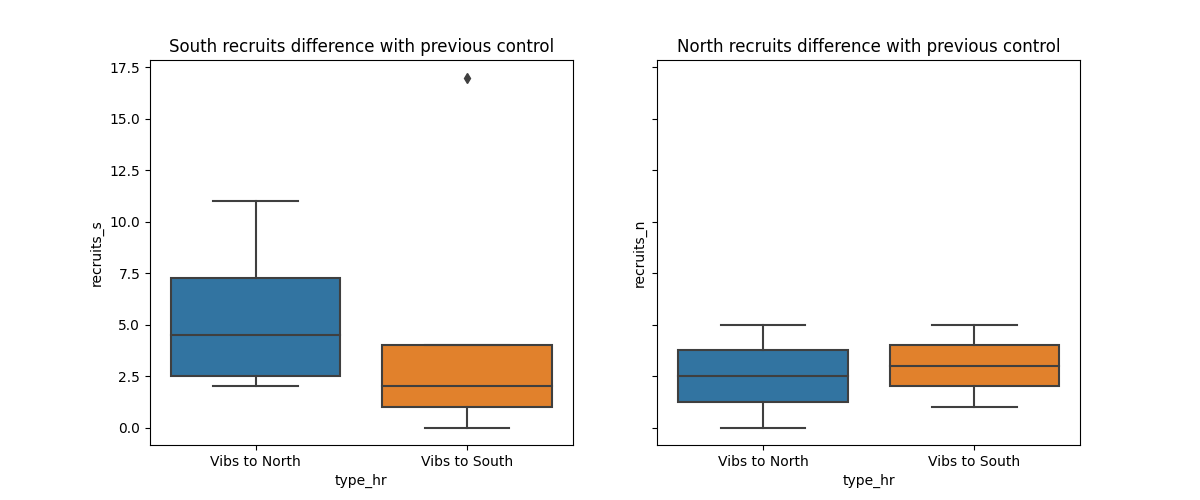

In [12]:
print("South recruits : {}".format(scipy.stats.ranksums(data2by2[data2by2.type == 2].recruits_s, data2by2[data2by2.type == 3].recruits_s)))
print("North recruits : {}".format(scipy.stats.ranksums(data2by2[data2by2.type == 2].recruits_n, data2by2[data2by2.type == 3].recruits_n)))
print("South recruits : {}".format(scipy.stats.ranksums(data2by2[data2by2.type == 2].recruits_s, data2by2[data2by2.type == 2].recruits_n)))
print("North recruits : {}".format(scipy.stats.ranksums(data2by2[data2by2.type == 3].recruits_s, data2by2[data2by2.type == 3].recruits_n)))

fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(12, 5), sharey=True)
seaborn.boxplot(data=data2by2, y='recruits_s', x='type_hr', ax=ax[0])
_ = ax[0].set_title('South recruits difference with previous control')
seaborn.boxplot(data=data2by2, y='recruits_n', x='type_hr', ax=ax[1])
_ = ax[1].set_title('North recruits difference with previous control')

In [13]:
# Group experiments 2-by-2 (previous control + actuation period)
data2by2_difference = []

flag_first_exp_control = False
last_day_characteristics = {}

for ind, dat in data.iterrows():
    if dat.type == 1:   # control period
        flag_first_exp_control                  = True
        last_day_characteristics['date']        = dat['dt']
        last_day_characteristics['starttime']   = dat.dtts_start
        last_day_characteristics['recruits_s']   = dat.recruits_s
        last_day_characteristics['recruits_n']   = dat.recruits_n
        continue
    else :              # actuation period
        if not(flag_first_exp_control): # if comes first --> not taken into account
            continue
        else :                          # if comes second
            if not(dat['dt'] == last_day_characteristics['date']): # if control was previous day
                flag_first_exp_control = False
                continue
            else :
                dat2by2 = {}
                dat2by2['dt']           = dat['dt']
                dat2by2['type']         = dat.type
                dat2by2['dtts_start']   = last_day_characteristics['starttime']
                dat2by2['dtts_stop']    = dat.dtts_stop
                dat2by2['duration']     = dat.dtts_stop - last_day_characteristics['starttime']
                # dat2by2['recruits_s']   = [dat.recruits_s/(last_day_characteristics['recruits_n'] + last_day_characteristics['recruits_s']) if (last_day_characteristics['recruits_n'] + last_day_characteristics['recruits_s'])!=0 else 0]
                # dat2by2['recruits_n']   = [dat.recruits_n/(last_day_characteristics['recruits_s'] + last_day_characteristics['recruits_n']) if (last_day_characteristics['recruits_n'] + last_day_characteristics['recruits_s'])!=0 else 0]
                dat2by2['recruits_s']   = last_day_characteristics['recruits_s'] - dat.recruits_s
                dat2by2['recruits_n']   = last_day_characteristics['recruits_n'] - dat.recruits_n
                dat2by2['type_hr']      = dat.type_hr
                flag_first_exp_control  = False
                data2by2_difference.append(dat2by2)
    
data2by2_difference = pandas.DataFrame.from_dict(data2by2_difference)
data2by2_difference

,dt,type,dtts_start,dtts_stop,duration,recruits_s,recruits_n,type_hr
0,2023-07-29 00:00:00+00:00,3.0,2023-07-29 13:00:00+00:00,2023-07-29 14:00:00+00:00,0 days 01:00:00,2.0,2.0,Vibs to North
1,2023-07-29 00:00:00+00:00,2.0,2023-07-29 14:00:00+00:00,2023-07-29 15:00:00+00:00,0 days 01:00:00,-1.0,-1.0,Vibs to South
2,2023-07-29 00:00:00+00:00,3.0,2023-07-29 15:00:00+00:00,2023-07-29 16:00:00+00:00,0 days 01:00:00,5.0,0.0,Vibs to North
3,2023-07-30 00:00:00+00:00,3.0,2023-07-30 10:00:00+00:00,2023-07-30 11:00:00+00:00,0 days 01:00:00,-5.0,1.0,Vibs to North
4,2023-07-30 00:00:00+00:00,2.0,2023-07-30 11:00:00+00:00,2023-07-30 12:00:00+00:00,0 days 01:00:00,11.0,2.0,Vibs to South
5,2023-07-30 00:00:00+00:00,3.0,2023-07-30 12:00:00+00:00,2023-07-30 13:00:00+00:00,0 days 01:00:00,2.0,0.0,Vibs to North
6,2023-07-30 00:00:00+00:00,2.0,2023-07-30 13:00:00+00:00,2023-07-30 14:00:00+00:00,0 days 01:00:00,0.0,-3.0,Vibs to South
7,2023-07-30 00:00:00+00:00,3.0,2023-07-30 14:00:00+00:00,2023-07-30 15:00:00+00:00,0 days 01:00:00,2.0,1.0,Vibs to North
8,2023-07-30 00:00:00+00:00,2.0,2023-07-30 15:00:00+00:00,2023-07-30 16:00:00+00:00,0 days 01:00:00,2.0,2.0,Vibs to South
9,2023-07-30 00:00:00+00:00,3.0,2023-07-30 16:00:00+00:00,2023-07-30 17:00:00+00:00,0 days 01:00:00,0.0,-1.0,Vibs to North


South recruits : RanksumsResult(statistic=-0.27386127875258304, pvalue=0.7841912294016191)
North recruits : RanksumsResult(statistic=-0.5477225575051661, pvalue=0.5838824207703652)
South Vibs : RanksumsResult(statistic=0.9400193421607683, pvalue=0.34720763934942456)
North Vibs : RanksumsResult(statistic=1.0408329997330663, pvalue=0.2979530616081678)


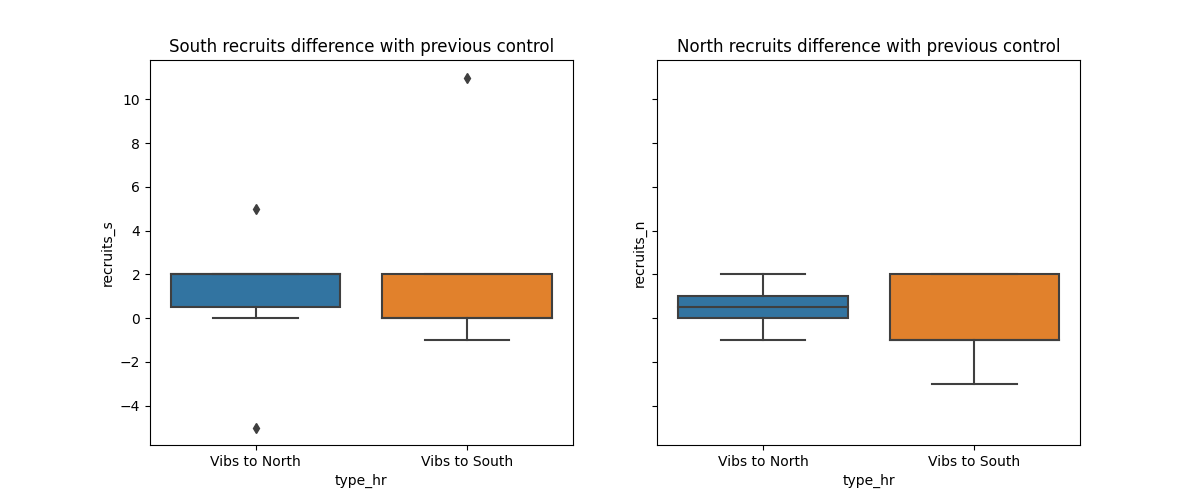

In [14]:
print("South recruits : {}".format(scipy.stats.ranksums(data2by2_difference[data2by2_difference.type == 2].recruits_s, data2by2_difference[data2by2_difference.type == 3].recruits_s)))
print("North recruits : {}".format(scipy.stats.ranksums(data2by2_difference[data2by2_difference.type == 2].recruits_n, data2by2_difference[data2by2_difference.type == 3].recruits_n)))
print("South Vibs : {}".format(scipy.stats.ranksums(data2by2_difference[data2by2_difference.type == 2].recruits_s, data2by2_difference[data2by2_difference.type == 2].recruits_n)))
print("North Vibs : {}".format(scipy.stats.ranksums(data2by2_difference[data2by2_difference.type == 3].recruits_s, data2by2_difference[data2by2_difference.type == 3].recruits_n)))

fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(12, 5), sharey=True)
seaborn.boxplot(data=data2by2_difference, y='recruits_s', x='type_hr', ax=ax[0])
_ = ax[0].set_title('South recruits difference with previous control')
seaborn.boxplot(data=data2by2_difference, y='recruits_n', x='type_hr', ax=ax[1])
_ = ax[1].set_title('North recruits difference with previous control')

In [15]:
# Group experiments 2-by-2 (actuation period - next control)
data2by2_difference_next = []

flag_first_exp_control = False
last_day_characteristics = {}

for ind, dat in data.iterrows():
    if dat.type != 1:   # not control period
        flag_first_exp_control                  = True
        last_day_characteristics['date']        = dat['dt']
        last_day_characteristics['starttime']   = dat.dtts_start
        last_day_characteristics['recruits_s']   = dat.recruits_s
        last_day_characteristics['recruits_n']   = dat.recruits_n
        last_day_characteristics['type']        = dat.type
        last_day_characteristics['type_hr']     = dat.type_hr
        continue
    else :              # control period
        if not(flag_first_exp_control): # if comes first --> not taken into account
            continue
        else :                          # if comes second
            if not(dat['dt'] == last_day_characteristics['date']): # if exp was previous day
                flag_first_exp_control = False
                continue
            else :
                dat2by2 = {}
                dat2by2['dt']           = dat['dt']
                dat2by2['type']         = last_day_characteristics['type']
                dat2by2['dtts_start']   = last_day_characteristics['starttime']
                dat2by2['dtts_stop']    = dat.dtts_stop
                dat2by2['duration']     = dat.dtts_stop - last_day_characteristics['starttime']
                # dat2by2['recruits_s']   = [dat.recruits_s/(last_day_characteristics['recruits_n'] + last_day_characteristics['recruits_s']) if (last_day_characteristics['recruits_n'] + last_day_characteristics['recruits_s'])!=0 else 0]
                # dat2by2['recruits_n']   = [dat.recruits_n/(last_day_characteristics['recruits_s'] + last_day_characteristics['recruits_n']) if (last_day_characteristics['recruits_n'] + last_day_characteristics['recruits_s'])!=0 else 0]
                dat2by2['recruits_s']   = last_day_characteristics['recruits_s'] - dat.recruits_s
                dat2by2['recruits_n']   = last_day_characteristics['recruits_n'] - dat.recruits_n
                dat2by2['type_hr']      = last_day_characteristics['type_hr']
                flag_first_exp_control  = False
                data2by2_difference_next.append(dat2by2)
    
data2by2_difference_next = pandas.DataFrame.from_dict(data2by2_difference_next)
data2by2_difference_next

,dt,type,dtts_start,dtts_stop,duration,recruits_s,recruits_n,type_hr
0,2023-07-29 00:00:00+00:00,3.0,2023-07-29 13:30:00+00:00,2023-07-29 14:30:00+00:00,0 days 01:00:00,0.0,-2.0,Vibs to North
1,2023-07-29 00:00:00+00:00,2.0,2023-07-29 14:30:00+00:00,2023-07-29 15:30:00+00:00,0 days 01:00:00,-4.0,1.0,Vibs to South
2,2023-07-29 00:00:00+00:00,3.0,2023-07-29 15:30:00+00:00,2023-07-29 16:30:00+00:00,0 days 01:00:00,0.0,0.0,Vibs to North
3,2023-07-30 00:00:00+00:00,3.0,2023-07-30 10:30:00+00:00,2023-07-30 11:30:00+00:00,0 days 01:00:00,-6.0,-1.0,Vibs to North
4,2023-07-30 00:00:00+00:00,2.0,2023-07-30 11:30:00+00:00,2023-07-30 12:30:00+00:00,0 days 01:00:00,1.0,1.0,Vibs to South
5,2023-07-30 00:00:00+00:00,3.0,2023-07-30 12:30:00+00:00,2023-07-30 13:30:00+00:00,0 days 01:00:00,-1.0,0.0,Vibs to North
6,2023-07-30 00:00:00+00:00,2.0,2023-07-30 13:30:00+00:00,2023-07-30 14:30:00+00:00,0 days 01:00:00,-4.0,2.0,Vibs to South
7,2023-07-30 00:00:00+00:00,3.0,2023-07-30 14:30:00+00:00,2023-07-30 15:30:00+00:00,0 days 01:00:00,0.0,-2.0,Vibs to North
8,2023-07-30 00:00:00+00:00,2.0,2023-07-30 15:30:00+00:00,2023-07-30 16:30:00+00:00,0 days 01:00:00,-1.0,-1.0,Vibs to South
9,2023-07-30 00:00:00+00:00,3.0,2023-07-30 16:30:00+00:00,2023-07-30 17:30:00+00:00,0 days 01:00:00,2.0,2.0,Vibs to North


South recruits : RanksumsResult(statistic=-0.5477225575051661, pvalue=0.5838824207703652)
North recruits : RanksumsResult(statistic=1.4605934866804429, pvalue=0.14412703481601533)
South Vibs : RanksumsResult(statistic=-1.775592090748118, pvalue=0.07580017458236125)
North Vibs : RanksumsResult(statistic=0.32025630761017426, pvalue=0.7487740417065472)


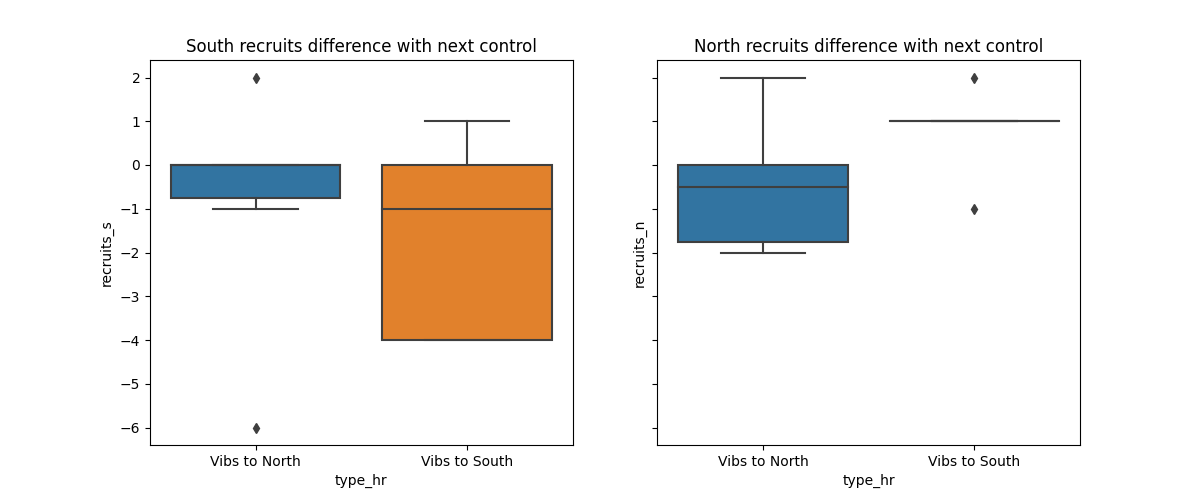

In [16]:
print("South recruits : {}".format(scipy.stats.ranksums(data2by2_difference_next[data2by2_difference_next.type == 2].recruits_s, data2by2_difference_next[data2by2_difference_next.type == 3].recruits_s)))
print("North recruits : {}".format(scipy.stats.ranksums(data2by2_difference_next[data2by2_difference_next.type == 2].recruits_n, data2by2_difference_next[data2by2_difference_next.type == 3].recruits_n)))

print("South Vibs : {}".format(scipy.stats.ranksums(data2by2_difference_next[data2by2_difference_next.type == 2].recruits_s, data2by2_difference_next[data2by2_difference_next.type == 2].recruits_n)))
print("North Vibs : {}".format(scipy.stats.ranksums(data2by2_difference_next[data2by2_difference_next.type == 3].recruits_s, data2by2_difference_next[data2by2_difference_next.type == 3].recruits_n)))


fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(12, 5), sharey=True)
seaborn.boxplot(data=data2by2_difference_next, y='recruits_s', x='type_hr', ax=ax[0])
_ = ax[0].set_title('South recruits difference with next control')
seaborn.boxplot(data=data2by2_difference_next, y='recruits_n', x='type_hr', ax=ax[1])
_ = ax[1].set_title('North recruits difference with next control')